In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install imutils
!pip install -q tensorflow-model-optimization

import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import numpy as np 
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25838 sha256=15ee4c959714c6a4ef6da3484df3bb8af03079e3ec7f1d4430ea2a86e1b1989a
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#KERAS LIB FOR CNN
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score

#lIBRARIES
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

Folder join

In [4]:
X_train = []
Y_train = []
image_size = 200
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('/kaggle/input/braintumor-augmented/Imagedataset/Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/braintumor-augmented/Imagedataset/Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [5]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(15264, 200, 200, 3)

Train TEST SPLIT

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=101)

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

CNN

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow_model_optimization.sparsity import keras as sparsity

from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(200,200)
conv_base = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True
    
model = conv_base.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= conv_base.input, outputs= model)

#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [9]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [10]:
train_len = len(X_train)
val_len = len(X_test)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
12211
-----------Validation Data length-----------------
3053


In [11]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=64, epochs=40, callbacks=callbacks)

Epoch 1/40
191/191 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.9033
Epoch 1: val_loss improved from inf to 0.41983, saving model to .mdl_wts.hdf5
191/191 [==============================] - 112s 330ms/step - loss: 0.2678 - accuracy: 0.9033 - val_loss: 0.4198 - val_accuracy: 0.8651 - lr: 1.0000e-04
Epoch 2/40
191/191 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9862
Epoch 2: val_loss improved from 0.41983 to 0.21647, saving model to .mdl_wts.hdf5
191/191 [==============================] - 58s 305ms/step - loss: 0.0429 - accuracy: 0.9862 - val_loss: 0.2165 - val_accuracy: 0.9351 - lr: 1.0000e-04
Epoch 3/40
191/191 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9923
Epoch 3: val_loss improved from 0.21647 to 0.13348, saving model to .mdl_wts.hdf5
191/191 [==============================] - 58s 305ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.1335 - val_accuracy: 0.9499 - lr: 1.0000e-04
Epoch 4/40
191/1

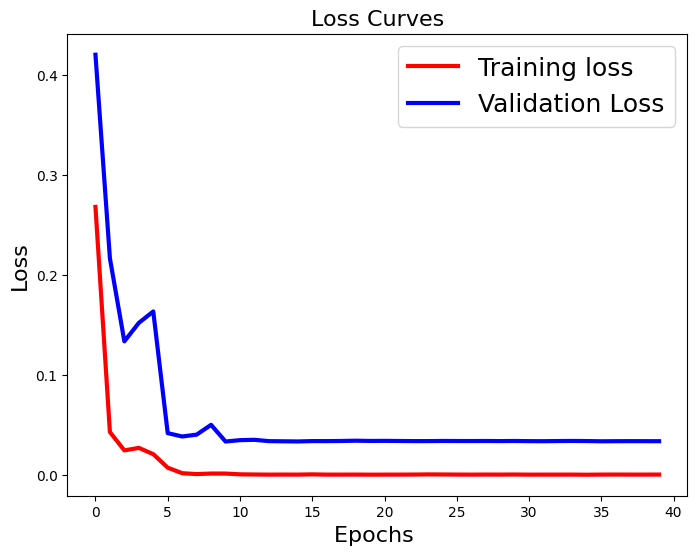

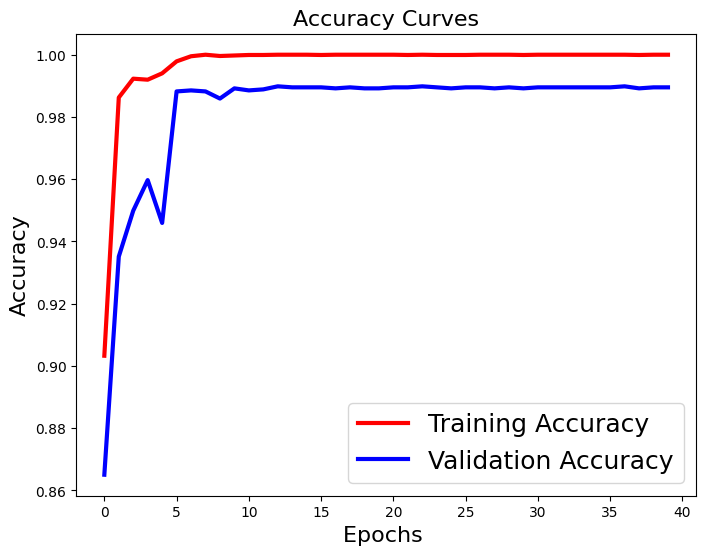

Baseline test accuracy: [0.0337371863424778, 0.9895185232162476]
Saved baseline model to: /tmp/tmp8xypjj80.h5


In [12]:

import tempfile
import tensorflow as tf

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

baseline_model_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)


keras_file = tempfile.mktemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)


In [13]:
import seaborn as sns
predicted_classes = np.argmax(model.predict(X_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
model.save('braintumor.h5')

model = load_model('/kaggle/working/braintumor.h5')
loss,acc = model.evaluate(X_test,y_test)


96/96 [==============================] - 5s 43ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       765
  meningioma       0.98      0.98      0.98       791
    no_tumor       1.00      1.00      1.00       724
   pituitary       0.99      1.00      0.99       773

    accuracy                           0.99      3053
   macro avg       0.99      0.99      0.99      3053
weighted avg       0.99      0.99      0.99      3053

96/96 [==============================] - 6s 47ms/step - loss: 0.0337 - accuracy: 0.9895


saving model and evaluating 

In [14]:
import tensorflow_model_optimization as tfmot
def apply_pruning_to_model(model):
    # Define the pruning parameters
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=0.5,
            begin_step=0,
            end_step=int(len(X_train) / 64) * 5
        )
    }

    # Define the pruning object
    pruning_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

    # Compile the model
    pruning_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
 # Create the pruning step callback
    pruning_callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep()
    ]

    return pruning_model, pruning_callbacks
# Apply weight pruning to the model and get pruning callbacks
pruned_model, pruning_callbacks = apply_pruning_to_model(model)

# Display model summary
pruned_model.summary()

# Train the pruned model
pruned_history = pruned_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=40,
    callbacks=callbacks + pruning_callbacks 
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 prune_low_magnitude_conv1_pad   (None, 206, 206, 3)  1          ['input_1[0][0]']                
 (PruneLowMagnitude)                                                                              
                                                                                                  
 prune_low_magnitude_conv1_conv  (None, 100, 100, 64  18882      ['prune_low_magnitude_conv1_pad[0
  (PruneLowMagnitude)           )                                ][0]']                       

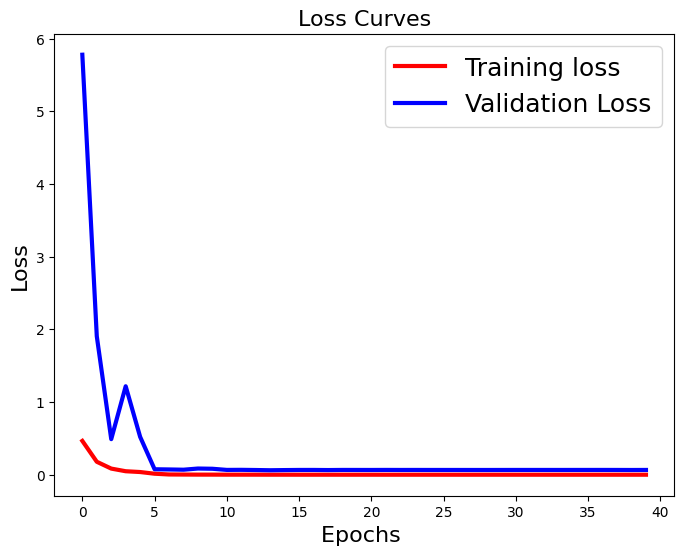

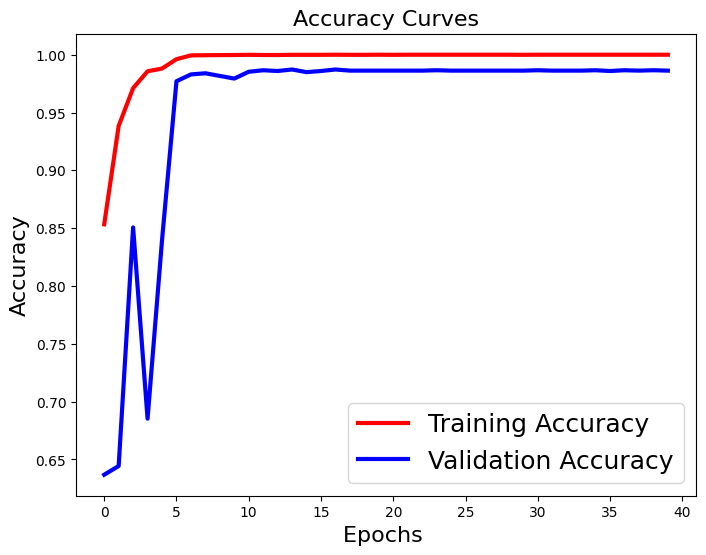

Pruned model test accuracy: [0.06594635546207428, 0.9862430691719055]
Saved pruned model to: /tmp/tmppfcnrp_u.h5


In [15]:
import tempfile
import tensorflow as tf

# Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(pruned_history.history['loss'],'r',linewidth=3.0)
plt.plot(pruned_history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

# Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(pruned_history.history['accuracy'],'r',linewidth=3.0)
plt.plot(pruned_history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

# Evaluate the pruned model
pruned_model_accuracy = pruned_model.evaluate(X_test, y_test, verbose=0)
print('Pruned model test accuracy:', pruned_model_accuracy)

# Save the pruned model
pruned_keras_file = tempfile.mktemp('.h5')
tf.keras.models.save_model(pruned_model, pruned_keras_file, include_optimizer=False)
print('Saved pruned model to:', pruned_keras_file)


In [16]:
import tensorflow_model_optimization as tfmot

def apply_pruning_to_model(model, X_train):
    # Define the pruning parameters with increased initial and final sparsity
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.2,  # Adjust the initial sparsity value as needed
            final_sparsity=0.7,    # Adjust the final sparsity value as needed
            begin_step=0,
            end_step=int(len(X_train) / 64) * 5
        )
    }

    # Define the pruning object
    pruning_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

    # Compile the model
    pruning_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    # Create the pruning step callback
    pruning_callbacks = [
        tfmot.sparsity.keras.UpdatePruningStep()
    ]

    return pruning_model, pruning_callbacks

# Apply weight pruning to the model and get pruning callbacks
pruned_model2, pruning_callbacks = apply_pruning_to_model(model, X_train)

# Display model summary
pruned_model2.summary()

# Train the pruned model
pruned_history2 = pruned_model2.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=40,
    callbacks=callbacks + pruning_callbacks 
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 prune_low_magnitude_conv1_pad   (None, 206, 206, 3)  1          ['input_1[0][0]']                
 (PruneLowMagnitude)                                                                              
                                                                                                  
 prune_low_magnitude_conv1_conv  (None, 100, 100, 64  18882      ['prune_low_magnitude_conv1_pad[0
  (PruneLowMagnitude)           )                                ][0]']                       

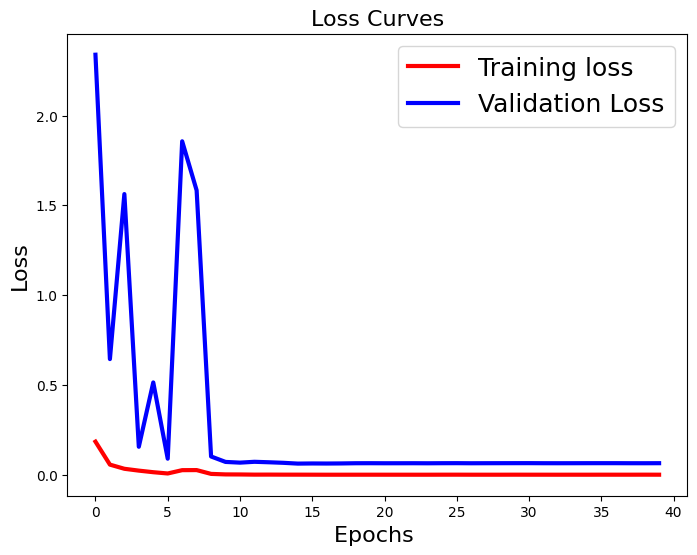

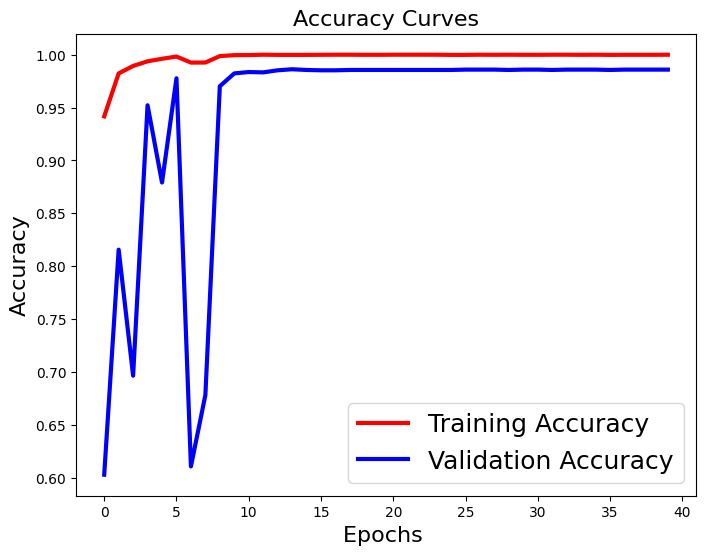

Pruned model test accuracy: [0.06444497406482697, 0.98591548204422]
Saved pruned model to: /tmp/tmpm3_vigdb.h5


In [17]:
import tempfile
import tensorflow as tf

# Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(pruned_history2.history['loss'],'r',linewidth=3.0)
plt.plot(pruned_history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

# Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(pruned_history2.history['accuracy'],'r',linewidth=3.0)
plt.plot(pruned_history2.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

# Evaluate the pruned model
pruned_model_accuracy = pruned_model2.evaluate(X_test, y_test, verbose=0)
print('Pruned model test accuracy:', pruned_model_accuracy)

# Save the pruned model
pruned_keras_file = tempfile.mktemp('.h5')
tf.keras.models.save_model(pruned_model2, pruned_keras_file, include_optimizer=False)
print('Saved pruned model to:', pruned_keras_file)


In [19]:
#pruned model 1 intial 0 final 50
import seaborn as sns
predicted_classes = np.argmax(pruned_model.predict(X_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))


96/96 [==============================] - 6s 44ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.97      0.97       765
  meningioma       0.98      0.97      0.97       791
    no_tumor       0.99      1.00      0.99       724
   pituitary       0.99      1.00      0.99       773

    accuracy                           0.98      3053
   macro avg       0.98      0.98      0.98      3053
weighted avg       0.98      0.98      0.98      3053



In [20]:
# pruned model 2 initial 20 final 70
import seaborn as sns
predicted_classes = np.argmax(pruned_model2.predict(X_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))


96/96 [==============================] - 6s 44ms/step
              precision    recall  f1-score   support

      glioma       0.98      0.97      0.97       765
  meningioma       0.98      0.97      0.97       791
    no_tumor       0.99      1.00      0.99       724
   pituitary       0.99      1.00      0.99       773

    accuracy                           0.98      3053
   macro avg       0.98      0.98      0.98      3053
weighted avg       0.98      0.98      0.98      3053

